In [1]:
import random
import warnings
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.metrics import fbeta_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
from torchvision import models

In [2]:
PATH = "./data/"
seed = 42
device = "cuda"

In [3]:
df = pd.read_csv(PATH + "train_v2.csv")

In [4]:
str_labels = df["tags"].str.split(" ").values

In [5]:
label_to_idx = {}
count = 0

for row in str_labels:
    for element in row:
        if element not in label_to_idx:
            label_to_idx[element] = count
            count += 1

In [6]:
train_df, val_df = train_test_split(df, test_size=0.1, random_state=seed)

Classes: clear primary


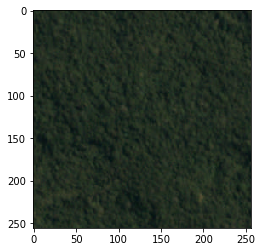

In [7]:
img = plt.imread(PATH + "train-jpg/" + train_df.iloc[0]["image_name"] + ".jpg")
print("Classes: " + train_df.iloc[0]["tags"])
plt.imshow(img[:, :, 0:3])
plt.show()

In [8]:
class SatelliteData(Dataset):
    def __init__(self, type_, df_, label_to_idx, p_flip=0.5):
        self.img_paths = df_["image_name"].values
        self.tags = df_["tags"].str.split(" ").values

        self.label_to_idx = label_to_idx

        self.type = type_
        self.path = PATH + "train-jpg/"
        self.postfix = ".jpg"

        self.p_flip = p_flip

        self.mean = (0.485, 0.456, 0.406)
        self.std = (0.229, 0.224, 0.225)

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        target = torch.zeros(len(self.label_to_idx))
        for element in self.tags[idx]:
            target[self.label_to_idx[element]] = 1

        img_path = self.path + self.img_paths[idx] + self.postfix
        img = Image.open(img_path)
  
        if self.type == "train" and random.random() < self.p_flip:
            img = TF.hflip(img)

        if self.type == "train" and random.random() < self.p_flip:
            img = TF.vflip(img)

        img = TF.to_tensor(img)
        img = img[0:3, :, :]  # It has 4-channels. Last-one seems to be unimportant (alpha?)
        img = TF.normalize(img, self.mean, self.std)

        return img, target

In [9]:
batch_size = 64

train_dataset = SatelliteData("train", train_df, label_to_idx)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

val_dataset = SatelliteData("val", val_df, label_to_idx)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [10]:
class Model(nn.Module):
    def __init__(self, num_classes, p=0.5):
        super().__init__()
        pretrained_model = list(models.resnet34(pretrained='imagenet').children())[:-1]
        self.backbone = nn.Sequential(*pretrained_model)
        self.linear = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.backbone(x)
        x = x.view(len(x), -1)
        x = self.linear(x)
        return x

In [11]:
threshold = 0.2
n_epochs = 5
lr = 1e-2

In [12]:
torch.manual_seed(seed)
model = Model(len(label_to_idx)).to(device)

optimizer = optim.Adam([
    {"params": model.backbone.parameters(), "lr": lr / 100},
    {"params": model.linear.parameters(), "lr": lr}]
)

In [13]:
loss_fct = nn.BCEWithLogitsLoss()

In [14]:
def f2_score(y_true, y_pred):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return fbeta_score(y_true, y_pred, 2, average='samples')

In [15]:
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

for epoch in range(0, n_epochs):
    train_loss, val_loss, train_f2, val_f2 = 0.0, 0.0, 0.0, 0.0

    model.train()
    for _, (x, y) in enumerate(train_loader):
            model.zero_grad()

            x, y = x.to(device), y.to(device)
            output = model(x)
            batch_loss = loss_fct(output, y)

            batch_loss.backward()
            optimizer.step()
            train_loss += batch_loss.detach().cpu().numpy() / x.shape[0]

            y_pred = (torch.sigmoid(output) > threshold).float().detach().cpu().numpy()
            y = y.cpu().numpy()
            train_f2 += f2_score(y, y_pred)

    model.eval()
    with torch.no_grad():
        for _, (x, y) in enumerate(val_loader):
                    x, y = x.to(device), y.to(device)
                    output = model(x)

                    batch_loss = loss_fct(output, y)
                    val_loss += batch_loss.cpu().numpy() / x.shape[0]                    

                    y_pred = (torch.sigmoid(output) > threshold).float().detach().cpu().numpy()
                    y = y.cpu().numpy()
                    val_f2 += f2_score(y, y_pred)

    train_loss = np.round(train_loss / len(train_loader), 6)
    val_loss = np.round(val_loss / len(val_loader), 6)

    train_f2 = np.round(train_f2 / len(train_loader), 6)
    val_f2 = np.round(val_f2 / len(val_loader), 6)

    print(f"------ Epoch: {epoch} ------")
    print(f"Train loss: {train_loss}")
    print(f"Val loss: {val_loss}")
    print(f"Train f2: {train_f2}")
    print(f"Val f2: {val_f2}")

------ Epoch: 0 ------
Train loss: 0.001834
Val loss: 0.001564
Train f2: 0.898225
Val f2: 0.914022
------ Epoch: 1 ------
Train loss: 0.001508
Val loss: 0.001485
Train f2: 0.917133
Val f2: 0.923294
------ Epoch: 2 ------
Train loss: 0.001491
Val loss: 0.001463
Train f2: 0.919072
Val f2: 0.924662
------ Epoch: 3 ------
Train loss: 0.001372
Val loss: 0.001426
Train f2: 0.924256
Val f2: 0.92627
------ Epoch: 4 ------
Train loss: 0.001334
Val loss: 0.001467
Train f2: 0.926347
Val f2: 0.92554
